# ASTR 596: FDS Homework 6: Hunting for Exoplanets
## Alex Gagliano
## Due: 04/02/2020

### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

## Finding Planet 1:
First, let's write a function to help with our planet hunting using the periodogram. We'll explain this function a bit later. 

In [1]:
%matplotlib inline
import lightkurve as lk
import gatspy
import numpy as np
from gatspy.periodic import LombScargle, LombScargleFast
import matplotlib.pyplot as plt
from numpy import ma 

# a method that, when passed the period and duration of a planet's transit, 
# masks the transits of that planet and returns the modified data
# inputs: t_start, the time of first transit
#         best_period, the period of the orbit found from the periodogram
#         lightcurve, the Kepler lightcurve data 
#         duration, the estimated data for the event
# outputs: clc_mod, the modified lightcurve after masking
def mask_lightcurve(t_start, best_period, lightcurve, duration):
    N = np.floor(lightcurve.time[-1]/best_period.value)
    times = t_start + np.arange(N+1)*best_period.value

    #make sure we haven't masked this data - otherwise the plot will 
    #show up as blank (learn by experience :) )
    window_center = t_start
    N_in_window = np.sum(np.logical_and(lightcurve.time >= (window_center - 5*duration), lightcurve.time <= (window_center + 5*duration)))
    while (N_in_window) == 0:
        window_center += best_period.value
        N_in_window = np.sum(np.logical_and(lightcurve.time >= (window_center - 5*duration), lightcurve.time <= (window_center + 5*duration)))

    flux_in_window = lightcurve.flux[np.logical_and(lightcurve.time >= (window_center - 5*duration), lightcurve.time <= (window_center + 5*duration))]
    ax = lightcurve.scatter();
    plt.axvline(x=window_center, c='r', linestyle='--')
    ax.axvspan(window_center-duration, window_center+duration, facecolor='r', alpha=0.3)
    ax.set_xlim((window_center - 5*duration, window_center + 5*duration));
    
    clc_mod = lightcurve.copy()
    times_L = times - duration
    times_R = times + duration
    idx = []
    for i in np.arange(N+1):
        i = int(i)
        tempMask = ma.masked_inside(clc_mod.time,times_L[i],times_R[i]).mask
        clc_mod.flux[tempMask] = np.nan
        clc_mod.remove_nans()
    return clc_mod

Visualizing the lightcurve:

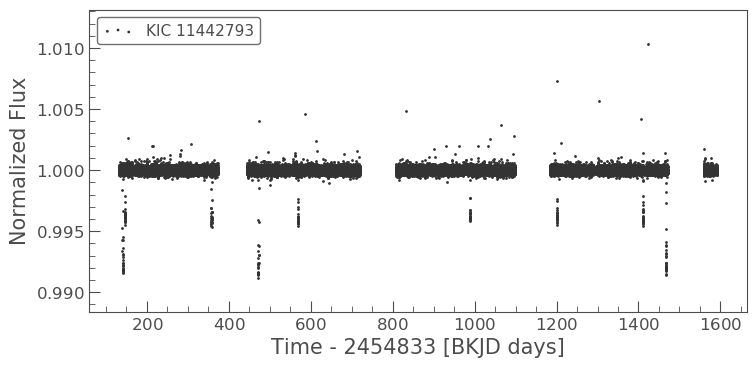

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

We next create a periodogram, which describes the degree to which our box least-squares method is optimized by a particular period in the range below:

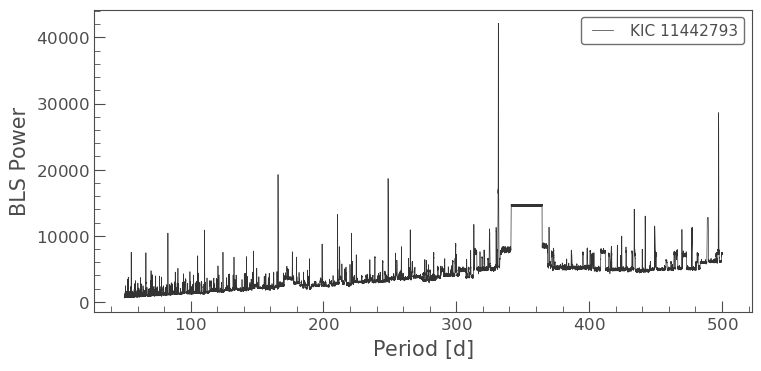

In [3]:
periodogram = clc.to_periodogram(method="bls", period=np.arange(50, 500, .01))
periodogram.plot();

Okay, so some strong signal around 350 days...Let's find the actual value: 

In [4]:
period = periodogram.period_at_max_power
t0 = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period))
print('Time of first transit: {:.3f}'.format(t0))

Best fit period: 331.610 d
Time of first transit: 140.487


Not far off with our by eye estimate, huh? Let's make sure this makes sense for the period for a planet, by folding our lightcurve: 

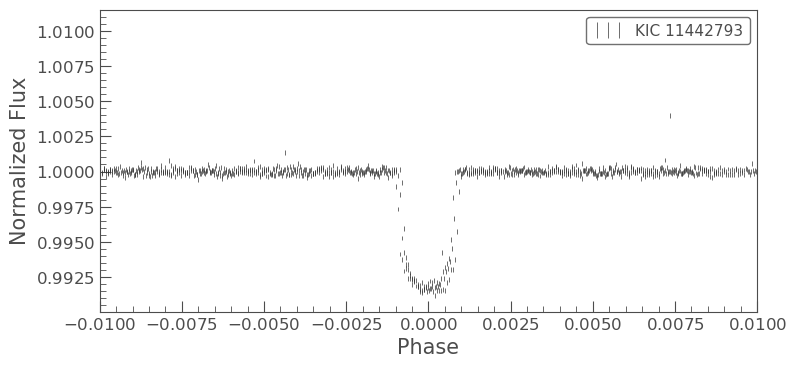

In [5]:
ax = clc.fold(period=period, t0=t0).errorbar();
ax.set_xlim(-0.01, 0.01);

Nice, we found the first planet, with a period of 331.610 days! Let's find the times of the transits:

In [6]:
N = np.floor(clc.time[-1]/period.value)
times = t0 + np.arange(N+1)*period.value

And, zooming in on the first transit, we'll estimate the transit duration (to subtract it from our data) 

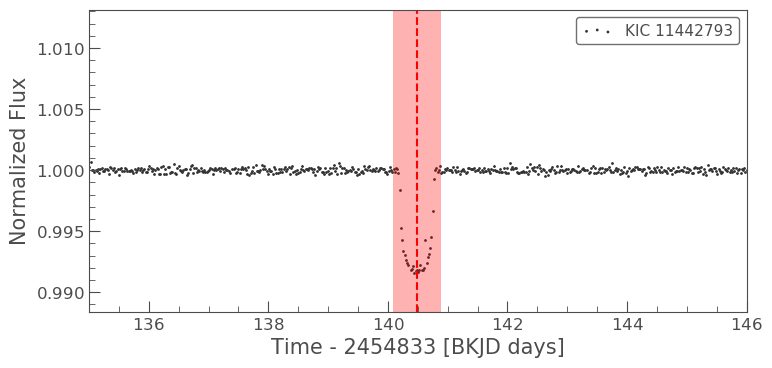

In [7]:
ax = clc.scatter();
duration = 0.4 # in days
plt.axvline(x=times[0], c='r', linestyle='--')
ax.axvspan(times[0]-duration, times[0]+duration, facecolor='r', alpha=0.3)
ax.set_xlim((135, 146));

That should be fine - let's now get rid of this data so that we can look for the next transit: 

In [8]:
clc_mod = clc.copy()
times_L = times - duration
times_R = times + duration
idx = []
for i in np.arange(N+1):
    i = int(i)
    tempMask = ma.masked_inside(clc_mod.time,times_L[i],times_R[i]).mask
    clc_mod.flux[tempMask] = np.nan
    clc_mod.remove_nans()

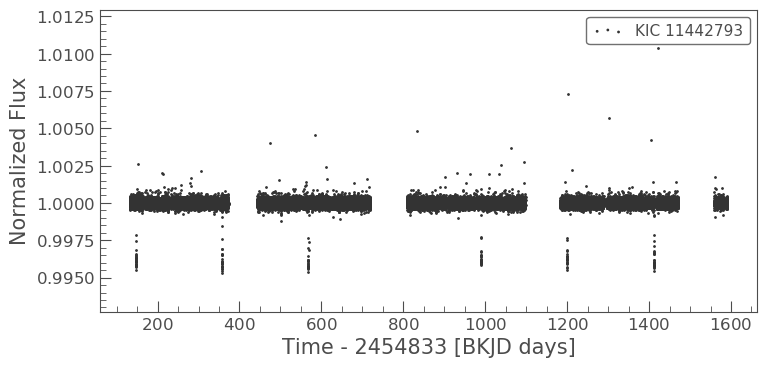

In [9]:
clc_mod.scatter();

Well-masked, if I do say so myself! I wrote this up in a function above (just went through the steps here for clarity), so we can execute all the same steps above like so:

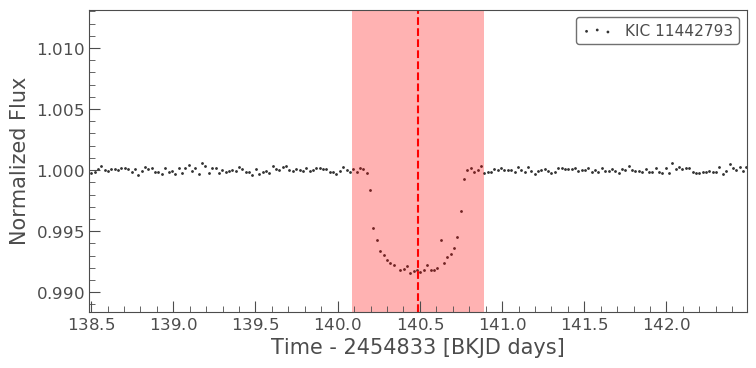

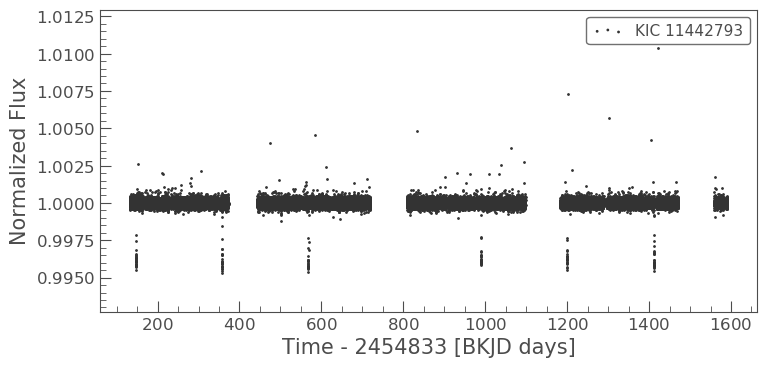

In [10]:
clc_mod = mask_lightcurve(t0, period, clc, 0.4)
clc_mod.scatter()

## Finding Planet 2:

Again, we start by looking at the periodogram to see where we have the most power:

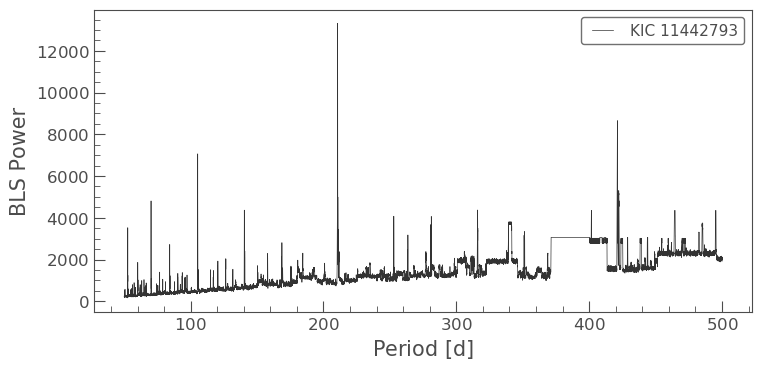

In [11]:
periodogram = clc_mod.to_periodogram(method="bls", period=np.arange(50, 500, .01))
periodogram.plot();

This time we have a period around 210 days - let's see where the max power is:

In [12]:
period2 = periodogram.period_at_max_power
t02 = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period2))
print('Time of first transit: {:.3f}'.format(t02))

Best fit period: 210.600 d
Time of first transit: 147.062


Beautiful. Executing our master function: 

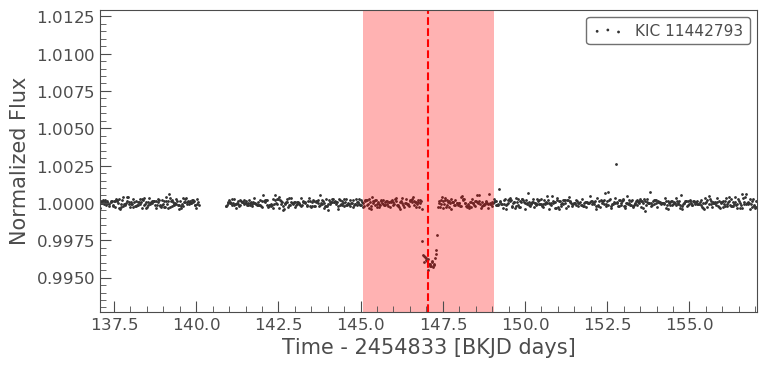

In [13]:
# increasing the mask width to ensure that we fully get rid of every transit
clc_mod2 = mask_lightcurve(t02, period2, clc_mod, 2)

Checking out our resulting lightcurve:

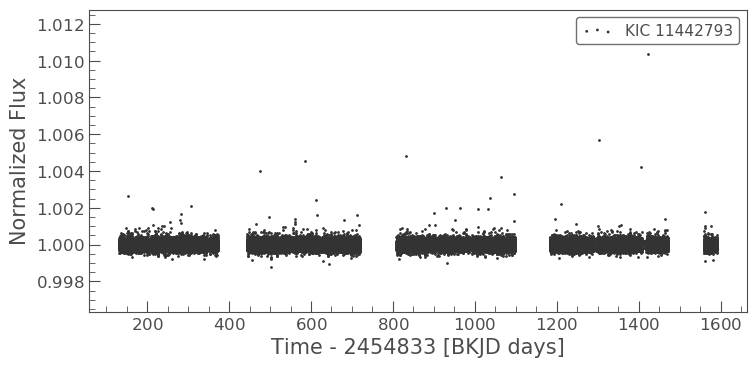

In [14]:
clc_mod2.scatter();

Nice. And, finally, our third planet:

## Boss Battle: Finding Planet 3

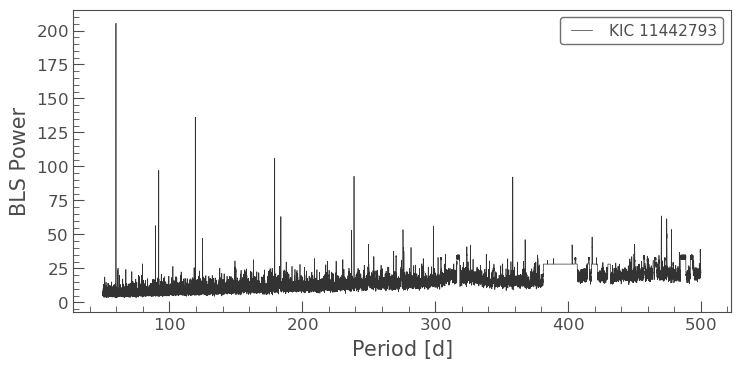

In [15]:
periodogram = clc_mod2.to_periodogram(method="bls", period=np.arange(50, 500, .01))
periodogram.plot();

This one's a short-period one! Transit of maybe 60 days? 

In [16]:
period3 = periodogram.period_at_max_power
t03 = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period3))
print('Time of first transit: {:.3f}'.format(t03))

Best fit period: 59.740 d
Time of first transit: 39.457


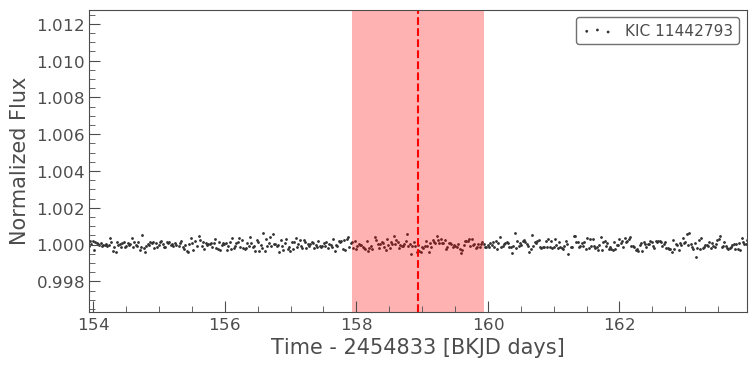

In [17]:
clc_mod3 = mask_lightcurve(t03, period3, clc_mod2, 1)

This one isn't so clear - did we actually find a planet? 

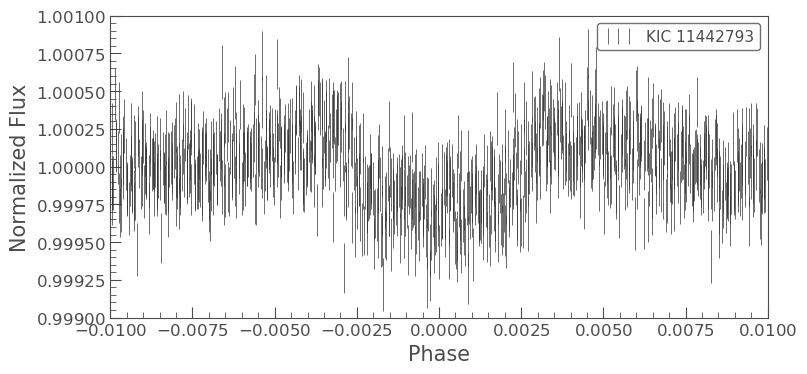

In [18]:
ax = clc_mod2.fold(period=period3, t0=t03).errorbar();
ax.set_xlim(-0.01, 0.01);
ax.set_ylim((0.999, 1.001));

We did indeed! In summary, we have three planets, with periods of: 

In [19]:
print('{:.3f}, {:.3f}, and {:.3f}.'.format(period, period2, period3))

331.610 d, 210.600 d, and 59.740 d.


From the wikipedia page, it looks like we've found Kepler-90 h, g, and d, respectively. showing all three together: 

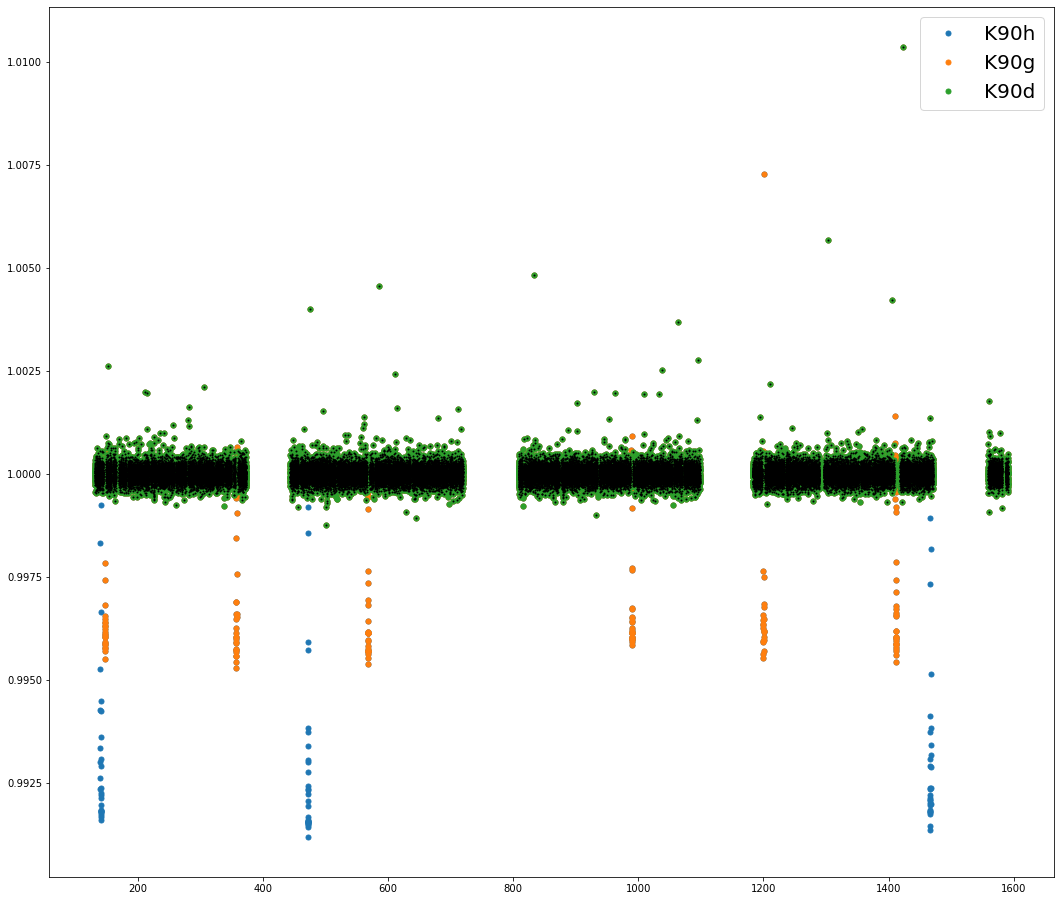

In [21]:
plt.figure(figsize=(18,16))
plt.plot(clc.time, clc.flux, 'o', markersize=5, label='K90h')
plt.plot(clc_mod.time, clc_mod.flux, 'o', markersize=5, label='K90g')
plt.plot(clc_mod2.time, clc_mod2.flux, 'o', markersize=5, label='K90d')
plt.plot(clc_mod3.time, clc_mod3.flux, 'o', markersize=1, c='k')
plt.legend(fontsize=20);

There should be 5 more planets, but we'll stop here. Sorry I didn't use gatspy!